Satellite images are returned by Python AWIPS as grids, and can be rendered with Cartopy pcolormesh the same as gridded forecast models in other python-awips examples. 

### Available Sectors and Products

In [44]:
from awips.dataaccess import DataAccessLayer

DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("satellite")

availableSectors = DataAccessLayer.getAvailableLocationNames(request)
availableSectors.sort()

for sector in availableSectors:
    print sector
    request.setLocationNames(sector)
    availableProducts = DataAccessLayer.getAvailableParameters(request)
    availableProducts.sort()
    for product in availableProducts:
        print " - " + product

AREA7201
 - Unknown-1
Arctic
 - Unknown-2
 - Unknown-4
 - Unknown-5
ECONUS
 - ACTP
 - ADP
 - AOD
 - CAPE
 - CH-01-0.47um
 - CH-02-0.64um
 - CH-03-0.87um
 - CH-04-1.38um
 - CH-05-1.61um
 - CH-06-2.25um
 - CH-07-3.90um
 - CH-08-6.19um
 - CH-09-6.95um
 - CH-10-7.34um
 - CH-11-8.50um
 - CH-12-9.61um
 - CH-13-10.35um
 - CH-14-11.20um
 - CH-15-12.30um
 - CH-16-13.30um
 - CSM
 - CTH
 - FDC Area
 - FDC Power
 - FDC Temp
 - KI
 - LI
 - LST
 - SI
 - TPW
 - TT
EFD
 - ACTP
 - ADP
 - AOD
 - CAPE
 - CH-01-0.47um
 - CH-02-0.64um
 - CH-03-0.87um
 - CH-04-1.38um
 - CH-05-1.61um
 - CH-06-2.25um
 - CH-07-3.90um
 - CH-08-6.19um
 - CH-09-6.95um
 - CH-10-7.34um
 - CH-11-8.50um
 - CH-12-9.61um
 - CH-13-10.35um
 - CH-14-11.20um
 - CH-15-12.30um
 - CH-16-13.30um
 - CSM
 - CTH
 - CTT
 - FDC Area
 - FDC Power
 - FDC Temp
 - KI
 - LI
 - LST
 - RRQPE
 - SI
 - SST
 - TPW
 - TT
 - VAH
 - VAML
EMESO-1
 - ACTP
 - ADP
 - CAPE
 - CH-01-0.47um
 - CH-02-0.64um
 - CH-03-0.87um
 - CH-04-1.38um
 - CH-05-1.61um
 - CH-06-2.25u

### GOES 16 Mesoscale Sectors Plot

Latest image available: 2018-02-11 20:04:28 (44m ago)
Image grid size: (727, 513)
Image grid extent: [-81.83214, -68.16786, 32.143394, 45.88625]
Latest image available: 2018-02-11 20:04:58 (44m ago)
Image grid size: (703, 606)
Image grid extent: [-95.21105, -78.94757, 30.756178, 44.556156]


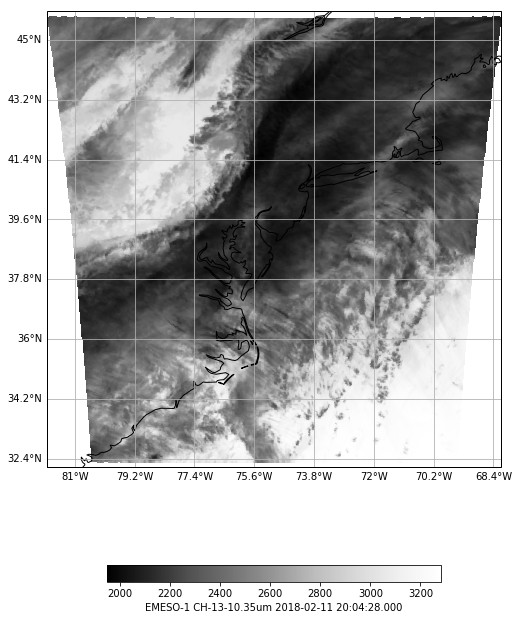

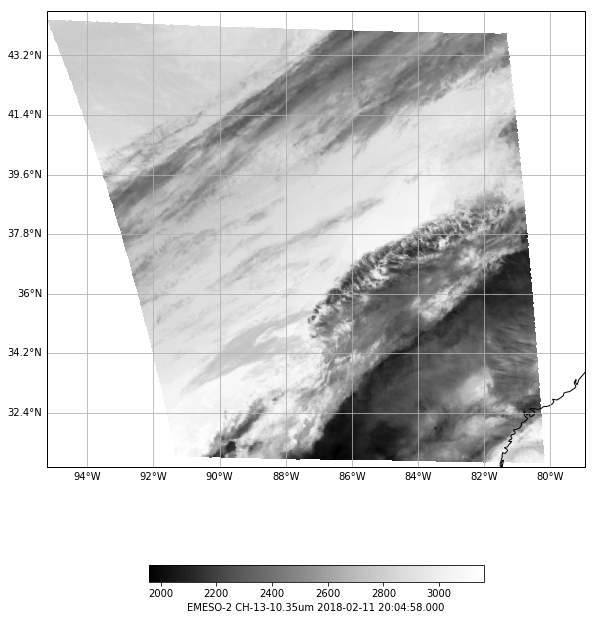

In [52]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import datetime

def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

sectors = ["EMESO-1","EMESO-2"]
fig = plt.figure(figsize=(16,7*len(sectors)))

for i, sector in enumerate(sectors):

    request = DataAccessLayer.newDataRequest()
    request.setDatatype("satellite")
    request.setLocationNames(sector)
    request.setParameters("CH-13-10.35um")

    utc = datetime.datetime.utcnow()
    times = DataAccessLayer.getAvailableTimes(request)
    hourdiff = utc - datetime.datetime.strptime(str(times[-1]),'%Y-%m-%d %H:%M:%S')
    hours,days = hourdiff.seconds/3600,hourdiff.days
    minute = str((hourdiff.seconds - (3600 * hours)) / 60)
    offsetStr = ''
    if hours > 0:
        offsetStr += str(hours) + "hr "
    offsetStr += str(minute) + "m ago"
    if days > 1:
        offsetStr = str(days) + " days ago"

    response = DataAccessLayer.getGridData(request, [times[-1]])
    grid = response[0]
    data = grid.getRawData()
    lons,lats = grid.getLatLonCoords()
    bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

    print("Latest image available: "+str(times[-1]) + " ("+offsetStr+")")
    print("Image grid size: " + str(data.shape))
    print("Image grid extent: " + str(list(bbox)))
    
    fig, ax = make_map(bbox=bbox)
    states = cfeat.NaturalEarthFeature(category='cultural',
                                        name='admin_1_states_provinces_lines',
                                        scale='50m', facecolor='none')
    ax.add_feature(states, linestyle=':')
    cs = ax.pcolormesh(lons, lats, data, cmap='Greys_r')
    cbar = fig.colorbar(cs, shrink=0.6, orientation='horizontal')
    cbar.set_label(str(grid.getLocationName())+" " \
                   +str(grid.getParameter())+" " \
                   +str(grid.getDataTime().getRefTime()))